# Test polynomials from FNFT

## Import

In [1]:
import sys
# adding signal_handling to the system path
sys.path.insert(0, '../signal_handling/')
sys.path.insert(0, '../nft_handling/')
sys.path.insert(0, '../pjt/')

from FNFTpy import nsev, nsev_poly
from FNFTpy import nsev_inverse, nsev_inverse_xi_wrapper
import numpy as np
import pandas as pd
import random
import timeit
from tqdm import tqdm
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift

import matplotlib.pyplot as plt
import matplotlib

from importlib import reload

import ssfm
reload(ssfm)

import signal_generation as sg
reload(sg)

import nft_analyse as nft
reload(nft)

import test_signals
from pjt import pjt

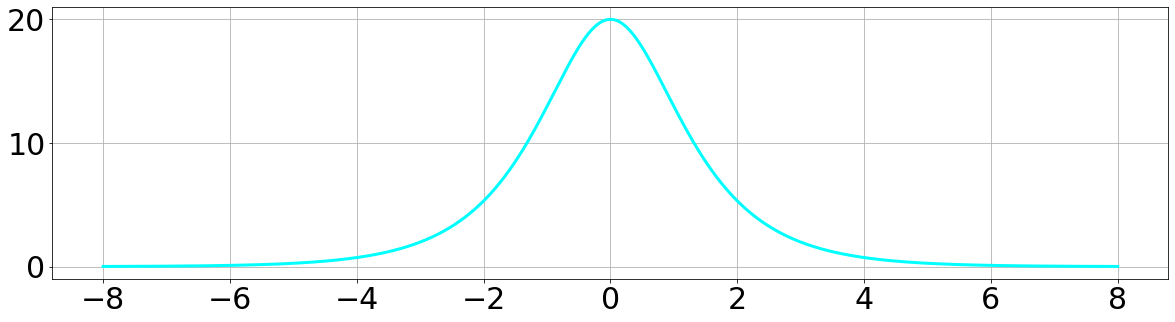

In [5]:
ampl = 20.0
chirp = 0.0

t_span = 16.0
n_t = 2 ** 10

dt = t_span / (n_t - 1)
t = np.array([i * dt - t_span / 2. for i in range(n_t)])

xi_span = np.pi / dt
n_xi = 2 ** 8
d_xi = xi_span / (n_xi - 1)
xi = np.array([i * d_xi - xi_span / 2. for i in range(n_xi)])

q, a_xi, b_xi, xi_discr, b_discr, r_discr, ad_discr = test_signals.get_sech(t, xi, a=ampl, c=chirp)

matplotlib.rcParams.update({'font.size': 30})
# color = ['red', 'blue', 'green', 'xkcd:light purple', 'xkcd:cyan']
fig, axs = plt.subplots(1, 1, figsize=(20, 5))
axs.plot(t, np.absolute(q), 'xkcd:cyan', linewidth=3)
axs.grid(True)

2 2048 2 0 0.0 -16.01564027370479
<class 'numpy.ndarray'>
256 256


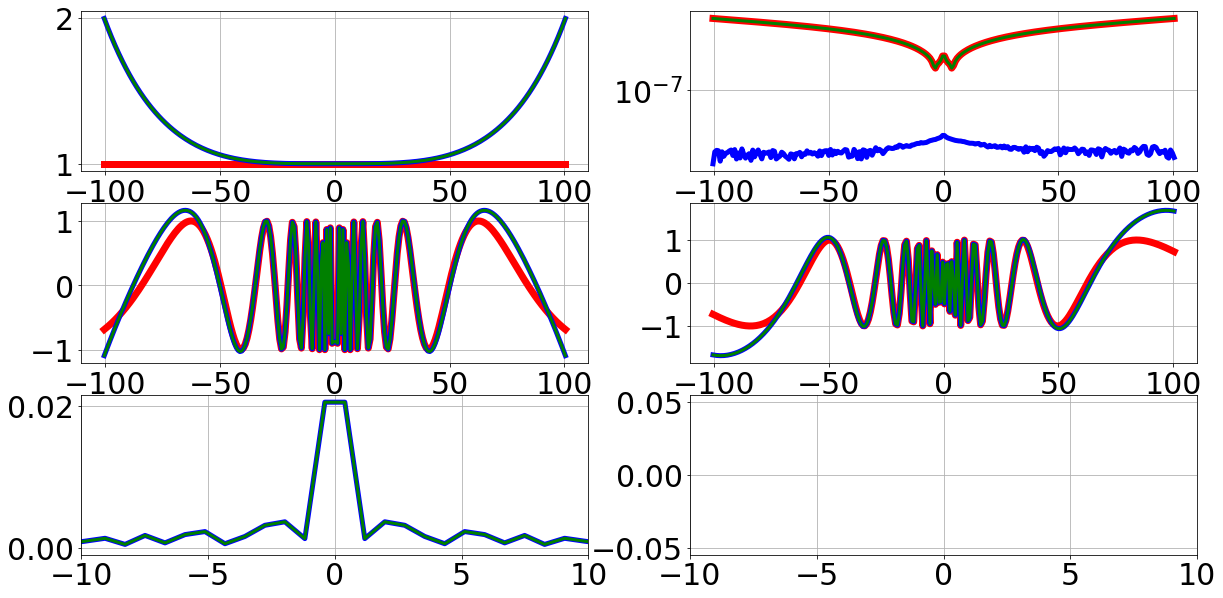

In [6]:
fnft_type = 11

res0 = nsev(q, t, xi[0], xi[-1], n_xi, dis=0, cst=1)
res = nsev(q, t, xi[0], xi[-1], n_xi, dis=fnft_type, cst=1)
a_fnft = res['cont_a']
b_fnft = res['cont_b']

res_poly = nsev_poly(q, t, dis=fnft_type)
a_coef = res_poly['coef_a']
b_coef = res_poly['coef_b']
ampl_scale = res_poly['ampl_scale']
deg = res_poly['deg']
deg1step = res_poly['deg1step']
deg1step_denom = res_poly['deg1step_denom']
phase_a = res_poly['phase_a']
phase_b = res_poly['phase_b']

print(ampl_scale, deg, deg1step, deg1step_denom, phase_a, phase_b)
print(type(a_coef))


# transform for spectral parameter z = e ^ (1j * xi * dt)
# z = np.exp(2j * xi / (deg1step - 2 * deg1step_denom) * dt)
z = np.exp(2j * xi / (deg1step - 2 * deg1step_denom) * dt)
# z_discr = np.exp(2j * xi_discr / (deg1step - 2 * deg1step_denom) * dt)

a_poly = np.polyval(ampl_scale * a_coef, z) * np.exp(1j * xi * phase_a)
b_poly = np.polyval(ampl_scale * b_coef, z) * np.exp(1j * xi * phase_b)
if fnft_type == 49 or fnft_type == 50:
    a_poly = a_poly * z ** (-2 * n_t)
    b_poly = b_poly * z ** (-2 * n_t)
    # a_poly = a_poly * np.exp(2j * xi / (deg1step - 2 * deg1step_denom) * dt * (-2 * n_t))
    # b_poly = b_poly * np.exp(2j * xi / (deg1step - 2 * deg1step_denom) * dt * (-2 * n_t))
print(np.size(a_poly), np.size(a_xi))

matplotlib.rcParams.update({'font.size': 30})
color = ['red', 'blue', 'green', 'xkcd:light purple', 'xkcd:cyan']
fig, axs = plt.subplots(3, 2, figsize=(20, 10))
axs[0][0].plot(xi, np.absolute(a_xi), color[0], linewidth=7)
axs[0][0].plot(xi, np.absolute(a_poly), color[1], linewidth=5)
axs[0][0].plot(xi, np.absolute(a_fnft), color[2], linewidth=3)
axs[0][0].grid(True)

axs[0][1].plot(xi, np.absolute(a_xi - a_poly), color[0], linewidth=7)
axs[0][1].plot(xi, np.absolute(a_fnft - a_poly), color[1], linewidth=5)
axs[0][1].plot(xi, np.absolute(a_xi - a_fnft), color[2], linewidth=3)
axs[0][1].set_yscale('log')
axs[0][1].grid(True)

axs[1][0].plot(xi, np.real(a_xi), color[0], linewidth=7)
axs[1][0].plot(xi, np.real(a_poly), color[1], linewidth=5)
axs[1][0].plot(xi, np.real(a_fnft), color[2], linewidth=3)
axs[1][0].grid(True)

axs[1][1].plot(xi, np.imag(a_xi), color[0], linewidth=7)
axs[1][1].plot(xi, np.imag(a_poly), color[1], linewidth=5)
axs[1][1].plot(xi, np.imag(a_fnft), color[2], linewidth=3)
axs[1][1].grid(True)

axs[2][0].plot(xi, np.absolute(b_xi / a_xi), color[0], linewidth=7)
axs[2][0].plot(xi, np.absolute(b_poly / a_poly), color[1], linewidth=5)
axs[2][0].plot(xi, np.absolute(b_fnft / a_fnft), color[2], linewidth=3)
axs[2][0].set_xlim(-10, 10)
axs[2][0].grid(True)

axs[2][1].plot(xi, np.absolute(b_xi / a_xi - b_poly / a_poly), color[0], linewidth=7)
# axs[2][1].plot(xi, np.absolute(b_fnft / a_fnft - b_poly / a_poly), color[1], linewidth=5)
axs[2][1].plot(xi, np.absolute(b_xi / a_xi - b_fnft / a_fnft), color[2], linewidth=3)
axs[2][1].set_xlim(-10, 10)
axs[2][1].grid(True)



In [7]:
print(np.mean(np.absolute(b_poly - b_xi)))
print(np.mean(np.absolute(b_fnft - b_xi)))
print(np.mean(np.absolute(b_poly - b_fnft)))
print(np.mean(np.absolute(a_poly - a_xi)))
print(np.mean(np.absolute(a_fnft - a_xi)))
print(np.mean(np.absolute(a_poly - a_fnft)))

nan
nan
2.0970578091087964e-13
0.2287946173482358
0.2287946173482852
2.9019017053961676e-13


In [8]:
disc_spec = np.array(pjt(n_t, q, t[0], t[-1], n_xi, a_fnft, omp_num_threads=8))
print(disc_spec)
print(res['bound_states'])
print(res0['bound_states'])

test_type='es4'
a_d_pjt, _ = nft.get_scattering_array(q, t, disc_spec, type=test_type)
a_d_fnft, _ = nft.get_scattering_array(q, t, res['bound_states'], type=test_type)
a_d_fnft0, _ = nft.get_scattering_array(q, t, res0['bound_states'], type=test_type)
print(np.absolute(a_d_pjt))
print(np.absolute(a_d_fnft))
print(np.absolute(a_d_fnft0))

[ 2.28769663e-29+19.49951124j  1.61296633e-33+18.49853372j
 -1.65303893e-39+17.49755621j  7.39557099e-32+16.49657869j
 -2.40741243e-34+15.49560117j -3.00926554e-36+14.49462365j
 -7.52316385e-37+13.49364614j  1.28189897e-30+12.49266862j
 -3.08148791e-32+11.4916911j  -1.04032398e-41+10.49071359j
  0.00000000e+00 +9.48973607j  7.22223729e-35 +8.48875855j
 -2.15239444e-42 +7.48778104j -6.46992091e-35 +6.48680352j
 -2.58608757e-37 +5.485826j    1.35181850e-37 +4.48484848j
 -2.61926472e-32 +3.48387097j  2.55787571e-35 +2.48289345j
 -3.45126646e-31 +1.48191593j -3.70764625e-29 +0.48083103j]
[ 8.85927774e-33+19.49980613j -6.41105364e-24+18.49982556j
 -2.66240556e-29+17.49984395j -1.16226004e-15+16.49986131j
  1.34331998e-15+15.49987765j -7.51876571e-19+14.49989295j
  1.82038570e-14+13.49990723j  8.62816615e-32+12.49992048j
 -2.30969920e-19+11.49993271j -1.82201624e-37+10.49994391j
 -1.20534089e-40 +9.49995409j  6.45718332e-42 +8.49996326j
  4.93038066e-32 +7.4999714j   2.79179908e-38 +6.499978